## 1. Import all the necessary libraries and packages

In [1]:
import os
import os.path
from pathlib import Path
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import plotly
import k3d

print('Successfully imported all libraries')

Successfully imported all libraries


## 2. Load the video and store it in a folder as contiguous png frames "person_[int].png"

In [2]:
from video_to_frames import video2frames                        # video_to_frames.py

path = "insert_path_to_video_of_interest"                       # insert the correct path here
video_path = os.path.normpath(path)

[success, numFrames] = video2frames(video_path)

assert success == True, print('Something went wrong')           # if False, print error and stop
assert numFrames > 0, print('Something went wrong')

Succesfully loaded video!
Successfully stored the video as 594 number of frames!


## 3. Drop the 100 unnecessary frames at the beginning and the end of the video with about 600 frames in it...

In [4]:
from drop_frames import drop_unnecessary_frames


path = "inser_path_to_the_video_of_interest"

# Does the same parsing as in the prev cell but also removes frames
numFrames = drop_unnecessary_frames(path, numFrames+1)

print('New reduced number of frames: ', numFrames)

Done dropping frames!
New number of frames:  396


## 4. Select two "views" to be considered for the reconstruction:

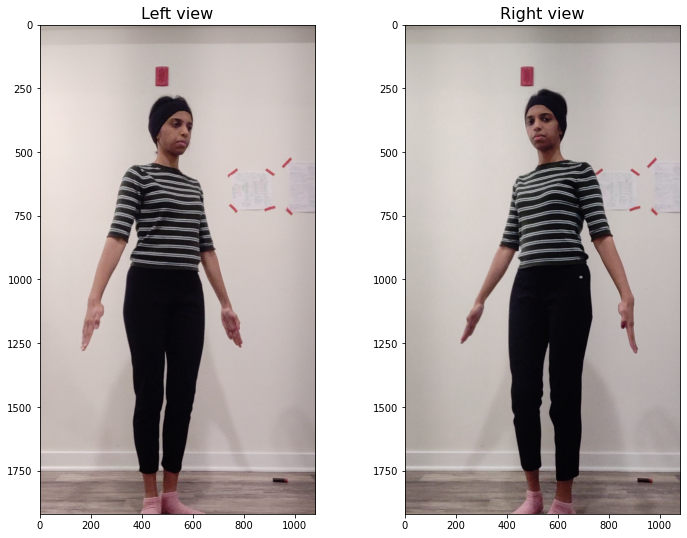

In [5]:
"""
# Begin a test run using two selected "views" from the many different views available from the video parsed in
# the previous cells.
"""


count_i = 145             # Frame numbers of the pairs of views being considered
count_j = 432             # Frame numbers of the pairs of views being considered

path_i = os.path.normpath("%s/person_%d.png" % (path, count_i))
path_j = os.path.normpath("%s/person_%d.png" % (path, count_j))

view_i = cv.imread(path_i)
view_j = cv.imread(path_j)


f, axs = plt.subplots(1, 2, figsize=(12, 9))

axs[0] = plt.subplot(1, 2, 1)
axs[0].set_title('Left view', fontsize=16)
dummy = axs[0].imshow(view_i[:,:,::-1])

axs[1] = plt.subplot(1, 2, 2)
axs[1].set_title('Right view', fontsize=16)
dummy = axs[1].imshow(view_j[:,:,::-1])


## 5. Erase the background features using pretrained ResNet based Segmentation

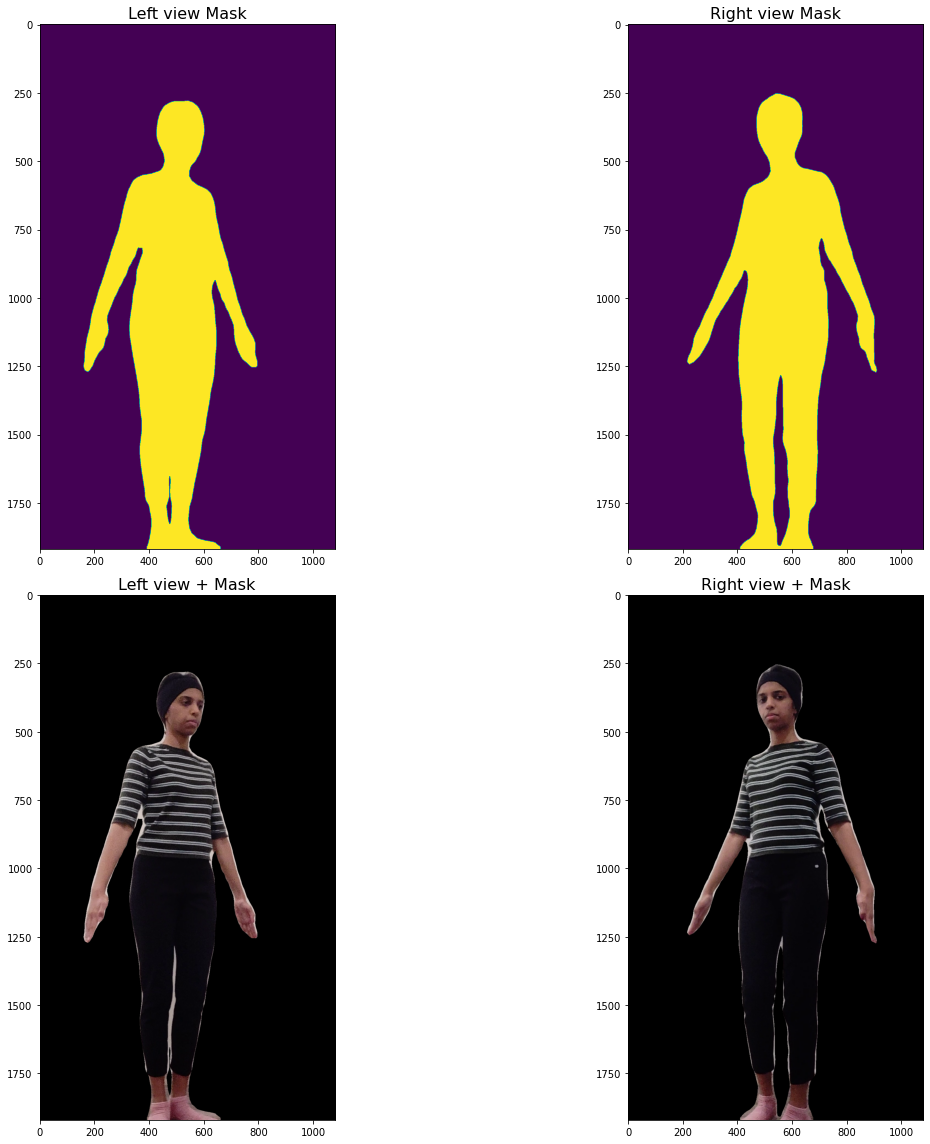

In [7]:
f, axs = plt.subplots(2, 2, figsize=(20, 16))

axs[0,0] = plt.subplot(2, 2, 1)
axs[0,0].set_title('Left view Mask', fontsize=16)
dummy = axs[0,0].imshow(mask_i)

axs[0,1] = plt.subplot(2, 2, 2)
axs[0,1].set_title('Right view Mask', fontsize=16)
dummy = axs[0,1].imshow(mask_j)


im_i = np.zeros_like(view_i)
im_j = np.zeros_like(view_j)

im_i[:,:,0] = view_i[:,:,0] * mask_i
im_i[:,:,1] = view_i[:,:,1] * mask_i
im_i[:,:,2] = view_i[:,:,2] * mask_i

im_j[:,:,0] = view_j[:,:,0] * mask_j
im_j[:,:,1] = view_j[:,:,1] * mask_j
im_j[:,:,2] = view_j[:,:,2] * mask_j

axs[1,0] = plt.subplot(2, 2, 3)
axs[1,0].set_title('Left view + Mask', fontsize=16)
dummy = axs[1,0].imshow(im_i[:,:,::-1])

axs[1,1] = plt.subplot(2, 2, 4)
axs[1,1].set_title('Right view + Mask', fontsize=16)
dummy = axs[1,1].imshow(im_j[:,:,::-1])

f.tight_layout()
plt.show()

## 6. Perform SIFT keypoint detection and match the keypoint between the images

type of kp_i:  <class 'tuple'>
type of kp_j:  <class 'tuple'>


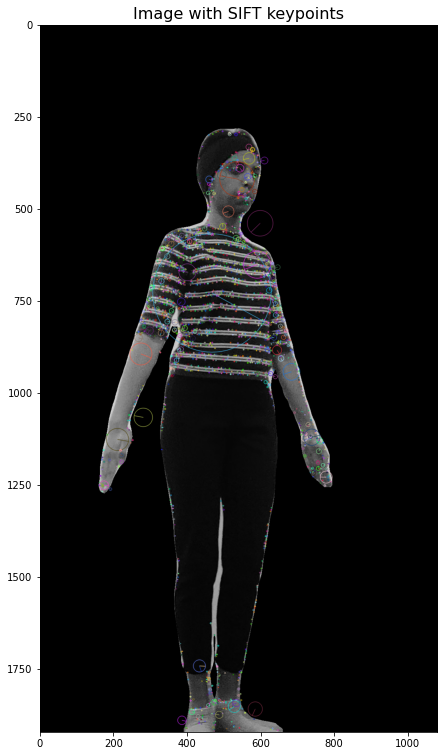

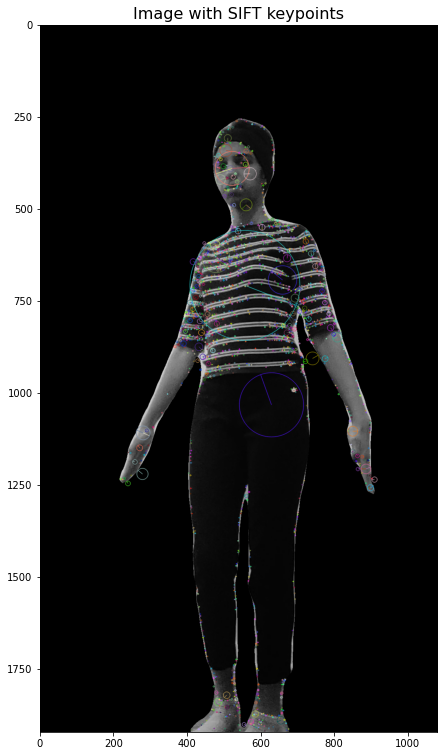

In [24]:
# Detects SIFT features in all of the images

keypoints = []
descriptions = []

def keypoint_detector(image):                                        # for the left and right images do...
    
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)       # Convert rgb --> grayscale images

    sift = cv.SIFT_create()                         # create a SIFT feature detector instance
    kp, des = sift.detectAndCompute(gray, None)     # find the keypoints and their descriptors
    
    # keypoints.append(kp)
    # descriptions.append(des)
    
    plt.figure(figsize=(13*2280/1080, 13))           # based on the One Plus Screen dimensions
    out_im = cv.drawKeypoints(gray, kp, gray, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.title('Image with SIFT keypoints', fontsize=16)
    plt.imshow(out_im)
    
    return kp, des


# kp_i, des_i = keypoint_detector(im_i)
# kp_j, des_j = keypoint_detector(im_j)

# print('type of kp_i: ', type(kp_i))
# print('type of kp_j: ', type(kp_j))

## 7. Match the keypoints detected on both images using SIFT

number of keypoint matches 488


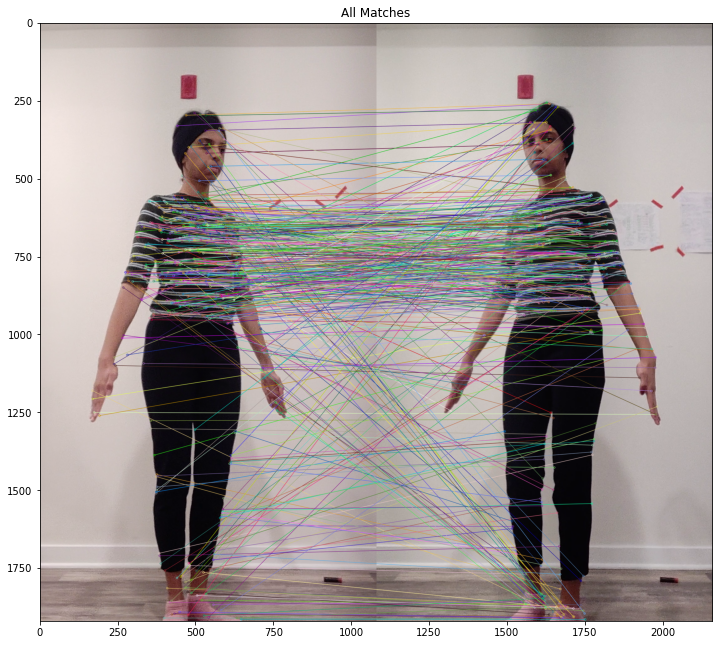

In [9]:
"""
"""# 1. The first approach to implementing SIFT
"""

bf      = cv.BFMatcher(crossCheck=True)                       # match keypoints between the two images!!
matches = bf.match(des_i, des_j)      # store the matches!

print("number of keypoint matches", len(matches))

# Draw Matches
matched_image = cv.drawMatches(view_i[:, :, ::-1], kp_i, view_j[:, :, ::-1], kp_j, matches, None, flags=2)
# matched_image = cv.drawMatches(im_i[:, :, ::-1], kp_i, im_j[:, :, ::-1], kp_j, matches, None, flags=2)

plt.figure(figsize=(11*2280/1080, 11))
plt.title("All Matches")
d = plt.imshow(matched_image)
"""

M: 
[[-1.69147311e+00 -1.10681369e-01  8.60452649e+02]
 [-1.67790424e+00 -1.97268987e-01  9.11936202e+02]
 [-2.18710653e-03 -5.34411684e-06  1.00000000e+00]]


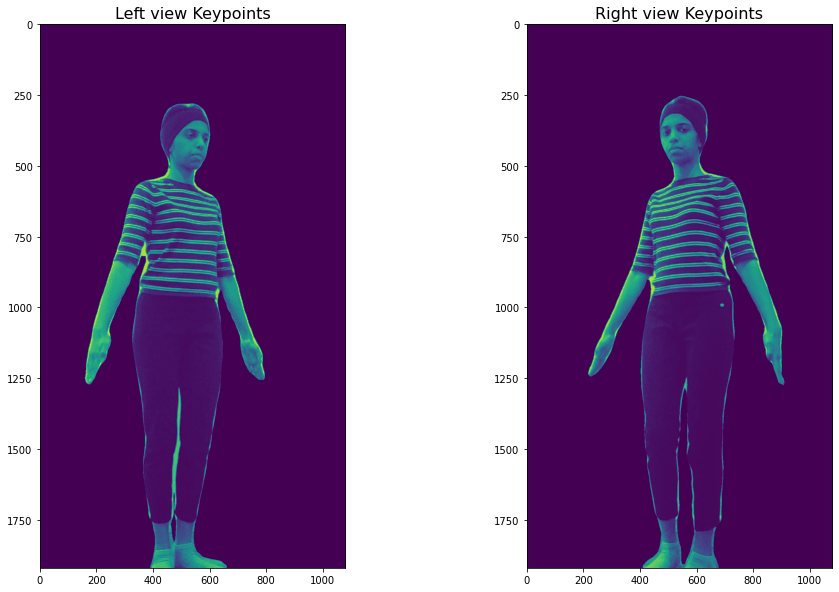

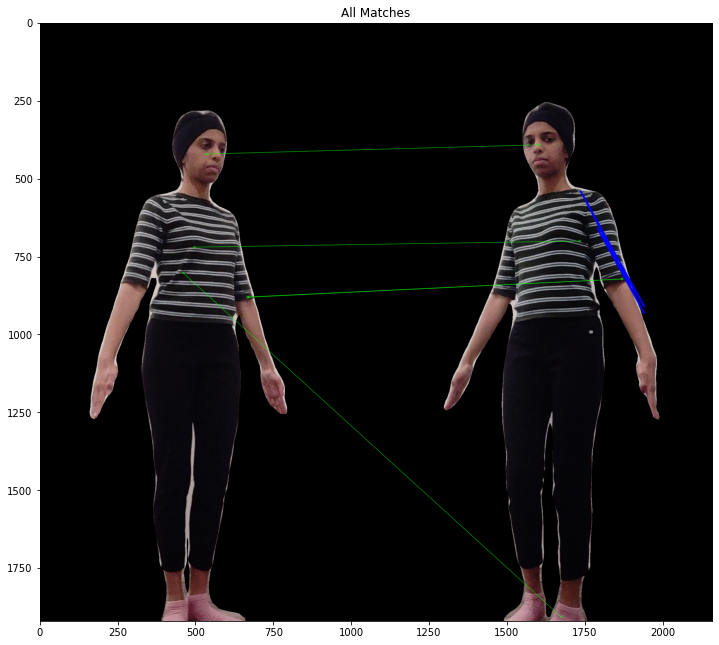

(<matplotlib.image.AxesImage at 0x7f7d13d9f190>, None)

In [30]:
"""# 2. A better SIFT implementation????
"""

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im_i, None)
kp2, des2 = sift.detectAndCompute(im_j, None)



FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
    
matched_image = cv.drawMatches(im_i[:,:,::-1], kp1, im_j[:,:,::-1], kp2, good, None, flags=2)

plt.figure(figsize=(11*2280/1080, 11))
plt.title("All Matches")
d = plt.imshow(matched_image)



# Find the Homography matrix
image_i = im_i.copy()
image_j = im_j.copy()

MIN_MATCH_COUNT = 10

print('Number of good matches: ', len(good))

if len(good) > MIN_MATCH_COUNT:
    
    src_pts_left  = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts_right = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    H, mask = cv.findHomography( src_pts_left, dst_pts_right, cv.RANSAC, 5.0 )   # Homography matrix
    print('M: ')
    print(M)
    
    matchesMask = mask.ravel().tolist()
    
    h = image_i.shape[0];    w = image_i.shape[1]
    
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    dst = cv.perspectiveTransform(pts, H)
    
    image_j = cv.polylines(image_j, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
    
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
        
        
draw_params = dict(matchColor = (0, 255, 0),    # draw matches in red color
                   singlePointColor = None,
                   matchesMask = matchesMask,   # draw only inliers
                   flags = 2)

img3 = cv.drawMatches(image_i, kp1, image_j, kp2, good, None, **draw_params)

plt.imshow(img3[:,:,::-1], alpha=0.9),plt.show()

## 8. Perform RANSAC and compute and plot and epipolar lines to calculate the true center of the images for the Calibration matrices K and K_prime which will be used for USAC in the next block!

type of kp_i :  <class 'tuple'>
type of kp_j :  <class 'tuple'>
F matrix : 
[[ 1.58908492e-06  1.80738956e-06 -3.06690185e-03]
 [-4.37029190e-07  8.07627183e-08 -5.51639894e-04]
 [ 3.40068688e-04 -2.99240540e-04  1.00000000e+00]]
E matrix: 
[[ 0.24754174  0.28154842 -0.87136328]
 [-0.06807878  0.01258092 -0.2642298 ]
 [ 0.29172013  0.10778379  0.22710437]]


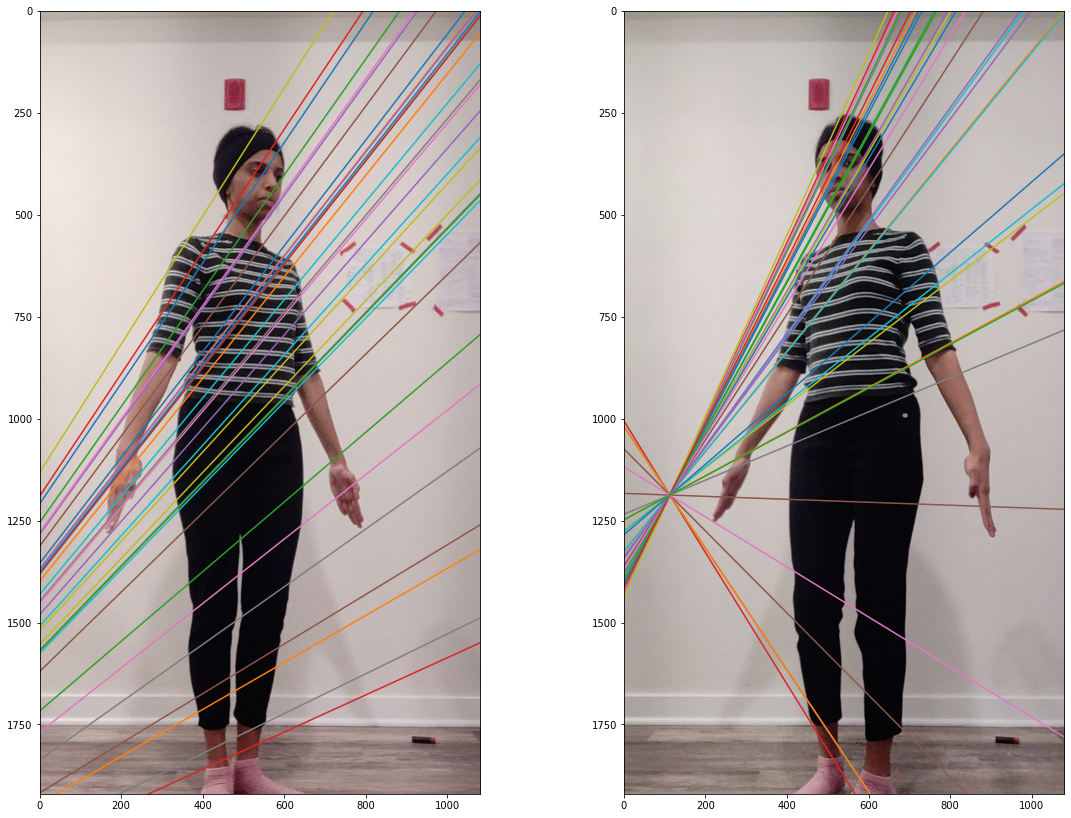

In [23]:
# Compute the alpha parameters of the calibration matrix using approximate intrinsics
# Reference: https://stackoverflow.com/questions/23943602/essential-matrix-from-fundamental-matrix-in-opencv
# f : focal length of the phone camera in mm
# k : pixel scale factor : 1 / (width of 1 pixel in mm)
from lse import least_squares_estimation
from plot_epi import plot_epipolar_lines



"""Set up the variables, assuming approximate image centers == half the height and the width
"""
k = 401 / 25.4      # UNITS: 1/mm      # One Plus 6 has a 401 ppi screen (25.4 mm = 1 inch)
f = 25              # UNITS: mm
alpha_u = k * f
alpha_v = alpha_u   # assuming the same value since all phones have the square pixels!

# ASSUME the image centers for the two images [u0, v0] and [u0_prime, v0_prime] are in the center of the images
# u0, v0             = im_i.shape[0]//2, im_i.shape[1]//2    # Assumed Centers, will be corrected in the next block
# u0_prime, v0_prime = im_j.shape[0]//2, im_j.shape[1]//2    # Assumed Centers, will be corrected in the next block
u0 = 307.5          # 
v0 = 205            #
u0_prime = u0
v0_prime = v0


# Compute the K matrix for the X1 keypoints from the left_view and...
# Compute the K_prime matrix for the X2 keypoints from the right_view
K = np.array([[alpha_u,       0,   u0],
              [      0, alpha_v,   v0],
              [      0,       0,    1]])

K_prime = np.array([[alpha_u,       0,   u0_prime],
                    [      0, alpha_v,   v0_prime],
                    [      0,       0,          1]])


# Can we compute F/E with uncalibrated keypoints?? Or does that matter only for custom ransac implementation
print('type of kp_i : ', type(kp_i))
print('type of kp_j : ', type(kp_j))

# Compute the calibrated points from the uncalibrated points
uncalib_i = np.array([[kp1[match.queryIdx].pt[0], kp1[match.queryIdx].pt[1], 1] for match in good])
#2. uncalib_i = np.array([[kp_i[match.queryIdx].pt, 1] for match in matches])
# kp1[m.queryIdx].pt
# uncalib_i = np.array([[kp1[m.queryIdx].pt, 1] for match in good])
uncalib_j = np.array([[kp2[match.trainIdx].pt[0], kp2[match.trainIdx].pt[1], 1] for match in good])
# uncalib_j = np.array([[kp2[m.queryIdx].pt, 1] for match in good])

calib_i = np.matmul(K, uncalib_i.T).T     # multiplying K with the uncalib pts to "calibrate" them
calib_j = np.matmul(K_prime, uncalib_j.T).T   # multiplying K with the uncalib pts to "calibrate" them

# F, status = cv.findFundamentalMat(kp_i, kp_j, cv.FM_RANSAC, ransacReprojThreshold=4, confidence=0.99, maxIters=10000)
F, status = cv.findFundamentalMat(uncalib_i, uncalib_j, cv.FM_RANSAC, ransacReprojThreshold=4, confidence=0.99, maxIters=10000)
E = K_prime.T @ F @ K


print('F matrix : ')
print(F)

print('E matrix: ')
print(E)


# Compute and plot epipolar lines
plot_epipolar_lines(view_i, view_j, uncalib_i.T, uncalib_j.T, E, F, plot=True)

In [ ]:
# plot_epipolar_lines(view_i, view_j, calib_i.T, calib_j.T, E, F, plot=True)

## 9. Calculate the camera pose using USAC/RANSAC for rectification of the 2 views

In [13]:
"""
# Not tractable. Arguments not in right formats

from ransac import ransac_estimator
# from lse import least_squares_estimator
from usac_magsac import FindFundamentalMatMAGSACplusplus

# F, status = cv.findFundamentalMat(uncalib_i, uncalib_j, cv.FM_RANSAC, ransacReprojThreshold=4, confidence=0.99, maxIters=10000)
E_usac, status = FindFundamentalMatMAGSACplusplus(uncalib_i, uncalib_j, K_prime, K, ransacReprojThreshold=4, confidence=0.99, maxIters=100000)

print('status = ', status, '\n')
print('E matrix with the USAC:')
print(E_usac)"""

status =  [[1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]] 

E matrix with the USAC:
[[-1.53908535  2.58102654 -2.81051505]
 [-1.73186309 -0.08768824  0.30988838]
 [ 2.87123929 -0.5367882   0.27794179]]


## 10. Compute the R and T for both the views

In [ ]:
from recon3d import reconstruct3D


"""
# Using the reconstruct3D to calculate the Rotation and translation between two frames necessary to rectify
# one of the two frames before the depth map can be calculated"""
P1, P2, T, R = reconstruct3D(E, calib_i, calib_j)

## 10. Rectify the two chosen images

In [ ]:
from two_view_stereo import (
    rectify_2view,
    compute_rectification_R,
    compute_right2left_transformation, )


R_iw, T_iw = np.eye(3), np.zeros((3,1))  # p_i = I @ p_w + 0 
R_jw, T_jw =        R ,           T      # p_j = R @ p_w + T


R_ij, T_ij, B = compute_right2left_transformation(R_iw, T_iw, R_jw, T_jw)
assert T_ij[1, 0] > 0, "here we assume view i should be on the left, not on the right"

R_irect = compute_rectification_R(T_ij)

rgb_i_rect, rgb_j_rect, K_i_corr, K_j_corr = rectify_2view(
    view_i["rgb"],
    view_j["rgb"],
    R_irect,
    R_irect @ R_ij,
    view_i["K"],
    view_j["K"],
    u_padding=20,
    v_padding=20,
)